## Monte Carlo Dropout
### Playing with house prices


In this notebook we explore the estimation of both aleatoric and epistemic uncertainty through Monte Carlo Dropout. A simple perceptron is used to model the regression problem which outputs the price prediction. The same dataset from the Direct Modelling experiment is used in order to allow for the comparison of the achieved estimation of aleatoric uncertainty.

![house prices](datasets/real_estate/house_prices.png)

The decomposition of uncertainty is carried out through the application of the following entropy-based formulas:

$$ \text{Total Uncertainty (TU)} = \mathcal{H} [p(y_i | x_i, D)] = \mathcal{H} [\mathbb{E}_{p(\theta | D)} [p(y_i | x_i, \theta)] $$


$$ \text{Aleatoric Uncertainty (AU)} = \mathbb{E}_{p(\theta | D)} [\mathcal{H} [p(y_i | x_i, \theta)]] $$
$$ \text{Epistemic Uncertainty (EU)} = \text{TU} - \text{AU} $$

In [1]:
import tqdm
import math
import torch
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns
from time import sleep
from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Paths, global vars
dt_folder = Path("./datasets")
dt_name = 'real_estate'

In [4]:
# Checks
assert dt_folder.exists()
assert dt_folder.is_dir()
assert (dt_folder / dt_name / (dt_name + '.csv')).exists()

#### Load Dataset

In [5]:
df = pd.read_csv(dt_folder / dt_name / (dt_name + '.csv'))

In [6]:
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [7]:
df.dtypes

No                                          int64
X1 transaction date                       float64
X2 house age                              float64
X3 distance to the nearest MRT station    float64
X4 number of convenience stores             int64
X5 latitude                               float64
X6 longitude                              float64
Y house price of unit area                float64
dtype: object

#### Prepare data

In [8]:
train, test = train_test_split(df, test_size=0.2)

In [9]:
class HouseDataset(torch.utils.data.Dataset):
    def __init__(self, df, scale=False):
        x = df.iloc[:, 1:7]
        y = df.iloc[:, 7]
        if scale:
            x = StandardScaler().fit_transform(x)
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

#### Model

In [10]:
class MLP(nn.Module):
    def __init__(self, rates):
        super().__init__()
        self.rates = rates
        self.dropout_1 = nn.Dropout(p=rates[0])
        self.dropout_2 = nn.Dropout(p=rates[1])
        self.dropout_3 = nn.Dropout(p=rates[2])
        
        self.dense_1 = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU()
        )
        self.dense_2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU()
        )
        self.dense_3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.dense_4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.linear = nn.Linear(32, 1)
        
    def forward(self, x, training=False):
        x = self.dense_1(x)
        if training:
            x = self.dropout_1(x)
        x = self.dense_2(x)
        if training:
            x = self.dropout_2(x)
        x = self.dense_3(x)
        if training:
            x = self.dropout_3(x)
        
        x = self.dense_4(x)
        return self.linear(x)

#### Train Loop

In [11]:
epochs = 200
batch_size = 64

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
mean_batch_loss = np.array([])
torch.manual_seed(42)

dt_train = HouseDataset(train, scale=True)
train_loader = torch.utils.data.DataLoader(dt_train, batch_size=batch_size, num_workers=2)

mlp = MLP([0.5, 0.5, 0.5])
mc_loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

mlp.train()
mlp.to(device)

MLP(
  (dropout_1): Dropout(p=0.5, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (dropout_3): Dropout(p=0.5, inplace=False)
  (dense_1): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
  )
  (dense_2): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
  )
  (dense_3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (dense_4): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
for epoch in range(epochs):
    tepoch = tqdm.tqdm(train_loader)
    tepoch.set_description(f"Epoch {epoch}")
    
    for i, obj in enumerate(tepoch):
        data, target = obj

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = mlp(data)
        # [batch_size, 1] -> [batch_size]
        output = torch.squeeze(output)
        
        out_loss = mc_loss(output, target)
        mean_batch_loss = np.append(mean_batch_loss, out_loss.item())

        out_loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=out_loss.item())
        sleep(0.1)

Epoch 199: 100%|████████████████████████| 6/6 [00:00<00:00,  7.12it/s, loss=12.9]


<AxesSubplot:>

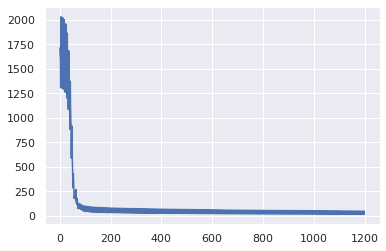

In [15]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=mean_batch_loss)

#### Testing the model

In [16]:
dt_test = HouseDataset(test, scale=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=batch_size, num_workers=2)

In [17]:
loss = np.array([])
pred = np.array([])

In [18]:
for i, obj in enumerate(test_loader):
    data, target = obj
    data, target = data.to(device), target.to(device)
    
    output = mlp(data)
    output = torch.squeeze(output)
    l = mc_loss(output, target)
    loss = np.append(loss, l.item())
    
    p = output.squeeze().cpu().detach().numpy()
    pred = np.concatenate((pred, p))

In [19]:
loss

array([ 53.07520294, 354.18231201])

In [20]:
plot_df = test.copy()
plot_df['pred'] = pred
plot_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred
381,382,2013.417,8.0,132.5469,9,24.98298,121.53981,47.3,56.156425
370,371,2012.750,15.9,289.3248,5,24.98203,121.54348,42.1,50.863731
42,43,2013.417,36.1,519.4617,5,24.96305,121.53758,34.7,42.939857
316,317,2013.250,13.3,250.6310,7,24.96606,121.54297,42.0,46.604816
285,286,2013.167,30.1,718.2937,3,24.97509,121.53644,55.3,33.345570
...,...,...,...,...,...,...,...,...,...
146,147,2012.750,0.0,185.4296,0,24.97110,121.53170,52.2,40.202114
283,284,2013.417,33.5,1978.6710,2,24.98674,121.51844,23.5,25.007973
89,90,2013.500,23.0,3947.9450,0,24.94783,121.50243,25.3,17.834204
170,171,2013.333,24.0,4527.6870,0,24.94741,121.49628,14.4,14.074020


#### Uncertainty Quantification

For the quantification of uncertainty, we utilise a model based on entropy proposed in prior literature.

$$ D = \{\{x1, y1\}, \{x2, y2\}, ..., \{x_n, y_n\}\} $$

$$ TU = \mathcal{H} [\mathbb{E}_{p(\theta | D)}(p(y | x, \theta))] $$
$$ AU = \mathbb{E}_{p(\theta | D)} [\mathcal{H}(p(y | x, \theta))] $$
$$ EU = TU - AU $$

In [21]:
def mc_dropout(data_loader, net, T):
    avg_preds = []
    for n in range(T):
        avg_sample_preds = []
        
        with torch.no_grad():
            for i, obj in enumerate(data_loader):
                data, target = obj
                data, target = data.to(device), target.to(device)

                # Training flag guarantees dropout is activated
                output = net(data, training=True)
                # [batch_size, 1] -> [batch_size]
                avg_sample_preds.extend(output.squeeze().cpu().detach().numpy())
                
        avg_preds.append(np.asarray(avg_sample_preds))
    return np.asarray(avg_preds)

In [22]:
def uq_decomposition(probs, mean):
    # mean = expected value, so entropy(mean) = TU
    tu = -np.sum(mean*np.log(mean), axis=-1) # shape (n_samples,)
    
    # AU average
    au = np.mean(-np.sum(probs*np.log(probs), axis=-1), axis=0) # shape (n_samples,)

    # EU average
    eu = tu - au
    
    return tu, au, eu

In [23]:
def uq(test_loader, net, T, display=False):
    # shape (T, samples)
    preds = mc_dropout(test_loader, net, T)
    # shape (samples)
    sample_means = np.mean(preds, axis=0)
    
    # Predictive distribution moments
    mean = np.mean(sample_means)
    variance = np.var(sample_means)
    std = np.sqrt(variance)
    
    import scipy
    norm = scipy.stats.norm(mean, std)
    prob_preds = np.asarray([norm.pdf(x) for x in preds])
    
    if display:
        sns.histplot(sample_means, bins=preds.shape[1]//2, kde=True)    
    
    tu, au, eu = uq_decomposition(prob_preds, sample_means)
    
    return mean, variance, tu, au, eu

In [24]:
dt_mc = HouseDataset(test, scale=True)
mc_loader = torch.utils.data.DataLoader(dt_mc, batch_size=batch_size, num_workers=2)

Mean> 39.75858
Variance> 140.35986
Mean TU> -12304.956
Mean AU> 5.584597112246151
Mean EU> -12310.540651799745


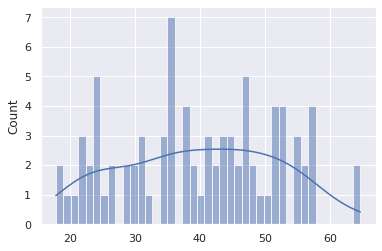

In [25]:
mean, variance, tu, au, eu = uq(mc_loader, mlp, 50, display=True)
print('Mean>', mean)
print('Variance>', variance)
print('Mean TU>', tu)
print('Mean AU>', au)
print('Mean EU>', eu)

$$ D = \{\{x1, y1\}, \{x2, y2\}, ..., \{x_n, y_n\}\} $$

$$ TU_i = \mathcal{H} [\mathbb{E}_{p(\theta | D)}(p(y_i | x_i, \theta)] $$
$$ AU_i = \mathbb{E}_{p(\theta | D)} [\mathcal{H}(p(y_i | x_i, \theta)] $$
$$ EU_i = TU_i - AU_i $$

In [26]:
def uq_sample(preds, sample_id, verbose=True):
    # Get number of passes
    T = preds.shape[0]
    
    preds_i = []
    for i in range(T):
        pred_i = preds[i, sample_id]
        preds_i.append(pred_i)
    preds_i = np.array(preds_i)
    
    mean = np.mean(preds_i, axis=0)
    variance = np.var(preds_i, axis=0)
    if verbose > 0:
        print('Mean (sample {}) > {}'.format(sample_id, mean))
        print('Variance (sample {}) > {}'.format(sample_id, variance))
        
    tu, au, eu = uq_decomposition(preds_i, mean)
    if verbose > 0:
        print('uq > ', tu, au, eu)
    
    return mean, variance, predicted, tu, au, eu

In [27]:
preds = mc_dropout(test_loader, mlp, 50)
uq_sample(preds, 0)

Mean (sample 0) > 57.638328552246094
Variance (sample 0) > 473.0496520996094


AxisError: axis 0 is out of bounds for array of dimension 0

#### Plotting with uncertainty

In [28]:
plot_df_mc = test.copy()
plot_df_mc['pred'] = mean
plot_df_mc['std'] = np.sqrt(variance)
plot_df_mc

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred,std
381,382,2013.417,8.0,132.5469,9,24.98298,121.53981,47.3,39.758579,11.847357
370,371,2012.750,15.9,289.3248,5,24.98203,121.54348,42.1,39.758579,11.847357
42,43,2013.417,36.1,519.4617,5,24.96305,121.53758,34.7,39.758579,11.847357
316,317,2013.250,13.3,250.6310,7,24.96606,121.54297,42.0,39.758579,11.847357
285,286,2013.167,30.1,718.2937,3,24.97509,121.53644,55.3,39.758579,11.847357
...,...,...,...,...,...,...,...,...,...,...
146,147,2012.750,0.0,185.4296,0,24.97110,121.53170,52.2,39.758579,11.847357
283,284,2013.417,33.5,1978.6710,2,24.98674,121.51844,23.5,39.758579,11.847357
89,90,2013.500,23.0,3947.9450,0,24.94783,121.50243,25.3,39.758579,11.847357
170,171,2013.333,24.0,4527.6870,0,24.94741,121.49628,14.4,39.758579,11.847357


In [29]:
plot_df_mc['upper'] = plot_df_mc['pred'] + plot_df_mc['std']
plot_df_mc['lower'] = plot_df_mc['pred'] - plot_df_mc['std']

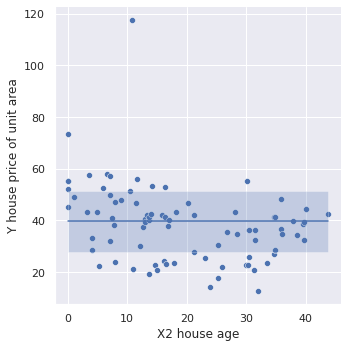

In [30]:
plot_df_mc = plot_df_mc.sort_values(by=['X2 house age'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X2 house age", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X2 house age", y="pred")
ax.fill_between(plot_df_mc['X2 house age'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25)

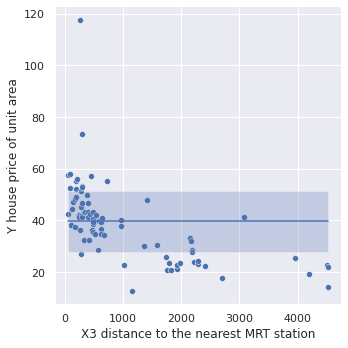

In [31]:
plot_df_mc = plot_df_mc.sort_values(by=['X3 distance to the nearest MRT station'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X3 distance to the nearest MRT station", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X3 distance to the nearest MRT station", y="pred")
ax.fill_between(plot_df_mc['X3 distance to the nearest MRT station'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25)

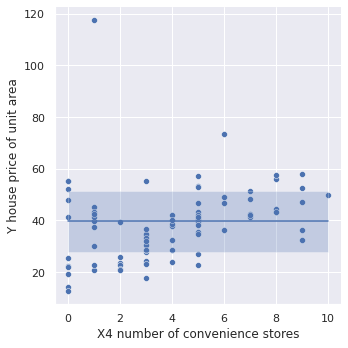

In [32]:
plot_df_mc = plot_df_mc.sort_values(by=['X4 number of convenience stores'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X4 number of convenience stores", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X4 number of convenience stores", y="pred", errorbar=None)
ax.fill_between(plot_df_mc['X4 number of convenience stores'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25, step='mid')